In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, broadcast, avg, coalesce, lit, count
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import time
import json


# Initialize SparkSession only once
spark = SparkSession.builder \
    .appName("lvb-spark") \
    .config('spark.master', 'local') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.0') \
    .getOrCreate()

# Optimize shuffle partitions based on your machine's cores
spark.conf.set("spark.sql.shuffle.partitions", "8")  # Adjust as needed

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4d110634-bbcb-4d27-b4b1-a04930d2ad0b;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 371ms :: artifacts dl 18ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       

In [2]:
start_time = time.time()

# Read enriched departures from Parquet file
df = spark.read.parquet("data/enriched_01.parquet")
print(f"Loaded Parquet data in {time.time() - start_time:.2f} seconds")

# Load line data
# Read the JSON file as a regular text file
start_time = time.time()
with open("data/relevantLines_with_stops.json", "r") as file:
    json_data = json.load(file)

# Create a list of rows
rows = [(line_id, line_info['name'], line_info['product']) for line_id, line_info in json_data.items()]

# Define the schema for the DataFrame
schema = StructType([
    StructField("line_id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("product", StringType(), True)
])

# Create the DataFrame
lines_df = spark.createDataFrame(rows, schema)

# Show the first few rows to verify
lines_df.show(5)
print(f"Loaded line data in {time.time() - start_time:.2f} seconds")

# Join the enriched departures with the line information
start_time = time.time()
joined_df = df.join(lines_df, df.lineId == lines_df.line_id, "left") \
    .select(df["*"], 
            lines_df.name.alias("line_name"), 
            lines_df.product.alias("line_product"))
joined_df.show(5)
print(f"Joined data in {time.time() - start_time:.2f} seconds")

Loaded Parquet data in 4.05 seconds


+--------------------+------+-------+
|             line_id|  name|product|
+--------------------+------+-------+
|5-naslvb-e-138822...| Bus E|    bus|
|         5-naslvb-n6|Bus N6|    bus|
|          8-naslvt-1| STR 1|   tram|
|          8-naslvt-2| STR 2|   tram|
|          8-naslvt-3| STR 3|   tram|
+--------------------+------+-------+
only showing top 5 rows

Loaded line data in 2.11 seconds


+---+--------------------+--------------------+-----+--------------------+-----------+-------------------+------+--------------------+-------------------+-----------+---------+------------+
|__v|                 _id|           crawlDate|delay|           direction|     lineId|        plannedWhen|stopId|              tripId|               when|added_delay|line_name|line_product|
+---+--------------------+--------------------+-----+--------------------+-----------+-------------------+------+--------------------+-------------------+-----------+---------+------------+
|  0|{657c06dc39987f76...|2023-12-15 07:57:...|    0|Naunhofer Straße ...|5-naslvb-74|2023-12-15 07:57:00|964061|1|1001850|0|81|15...|2023-12-15 07:57:00|          0|   Bus 74|         bus|
|  0|{657c0791fc07f576...|2023-12-15 08:00:...|    0|Naunhofer Straße ...|5-naslvb-74|2023-12-15 07:58:00|956577|1|1001850|0|81|15...|2023-12-15 07:58:00|          0|   Bus 74|         bus|
|  0|{657c078ffc07f576...|2023-12-15 08:00:...|   

In [3]:
# Calculate average delay grouped by product and collect example line names
delay_by_product = joined_df.groupBy("line_product") \
    .agg(F.avg("delay").alias("avg_delay"), 
         F.count("*").alias("count"),
         F.collect_set("line_name").alias("line_names")) \
    .orderBy(F.desc("avg_delay"))

# Function to limit array to 5 elements and format as string
def limit_and_format(arr):
    limited = arr[:5]
    return ", ".join(limited) + ("..." if len(arr) > 5 else "")

# Register the UDF
limit_and_format_udf = F.udf(limit_and_format, StringType())

# Apply the UDF to the line_names column
delay_by_product_with_examples = delay_by_product.withColumn(
    "example_lines", 
    limit_and_format_udf(F.col("line_names"))
)

# Show the results
delay_by_product_with_examples.select(
    "line_product", 
    F.round("avg_delay", 2).alias("avg_delay"), 
    "count", 
    "example_lines"
).show(truncate=False)

+------------+---------+-------+------------------------------------------+
|line_product|avg_delay|count  |example_lines                             |
+------------+---------+-------+------------------------------------------+
|regional    |135.04   |973    |Bus S3, Bus S5, Bus S2, Bus S4            |
|suburban    |132.68   |379400 |S 5, S 5X, S 2, S 6, S 1...               |
|tram        |101.66   |2640642|STR 14, STR 50, STR 34, STR 4, STR 16...  |
|bus         |98.71    |1672273|Bus N60, Bus N5, Bus 90, Bus 76, Bus 89...|
+------------+---------+-------+------------------------------------------+



In [4]:
# Merge regional and suburban products
merged_df = delay_by_product_with_examples.withColumn(
    "line_product",
    F.when(F.col("line_product").isin(["regional", "suburban"]), "suburban")
     .otherwise(F.col("line_product"))
)

# Recalculate the aggregations with the merged products
merged_delay_by_product = merged_df.groupBy("line_product") \
    .agg(F.avg("avg_delay").alias("avg_delay"), 
         F.sum("count").alias("count"),
         F.flatten(F.collect_list("line_names")).alias("line_names")) \
    .orderBy(F.desc("avg_delay"))

# Apply the UDF to the merged results
merged_delay_with_examples = merged_delay_by_product.withColumn(
    "example_lines", 
    limit_and_format_udf(F.col("line_names"))
)

# Show the results with merged regional and suburban
merged_delay_with_examples.select(
    "line_product", 
    F.round("avg_delay", 2).alias("avg_delay"), 
    "count", 
    "example_lines"
).show(truncate=False)


+------------+---------+-------+------------------------------------------+
|line_product|avg_delay|count  |example_lines                             |
+------------+---------+-------+------------------------------------------+
|suburban    |133.86   |380373 |Bus S3, Bus S5, Bus S2, Bus S4, S 5...    |
|tram        |101.66   |2640642|STR 14, STR 50, STR 34, STR 4, STR 16...  |
|bus         |98.71    |1672273|Bus N60, Bus N5, Bus 90, Bus 76, Bus 89...|
+------------+---------+-------+------------------------------------------+



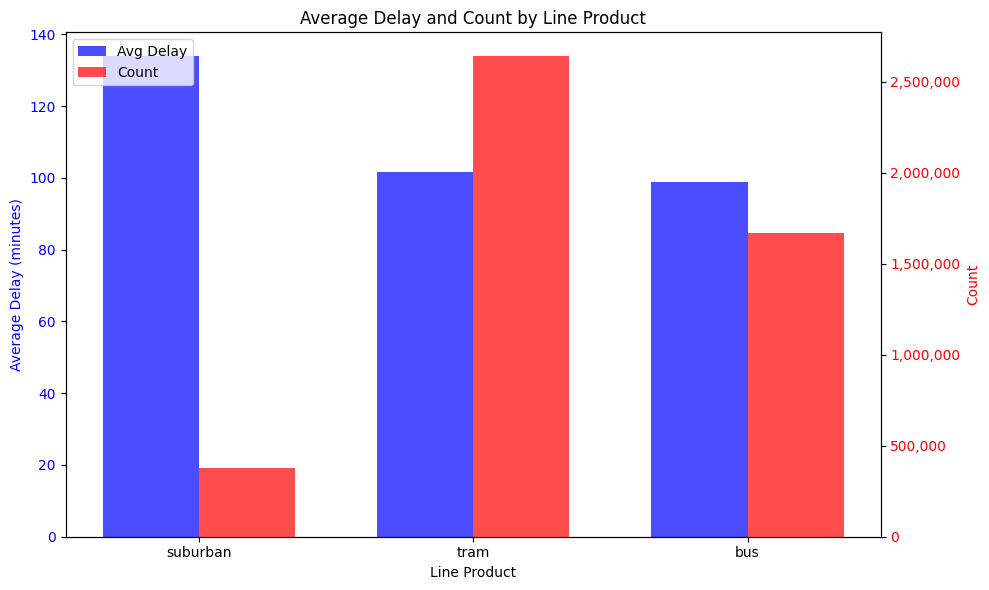

In [5]:
# Convert Spark DataFrame to Pandas DataFrame
pdf = merged_delay_with_examples.select(
    "line_product", 
    F.round("avg_delay", 2).alias("avg_delay"), 
    "count"
).toPandas()

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average delay on the left y-axis
bar_width = 0.35
x = range(len(pdf['line_product']))
ax1.bar([i - bar_width/2 for i in x], pdf['avg_delay'], width=bar_width, color='b', alpha=0.7, label='Avg Delay')
ax1.set_xlabel('Line Product')
ax1.set_ylabel('Average Delay (minutes)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create the second y-axis and plot count
ax2 = ax1.twinx()
ax2.bar([i + bar_width/2 for i in x], pdf['count'], width=bar_width, color='r', alpha=0.7, label='Count')
ax2.set_ylabel('Count', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Format y-axis labels to use commas as thousand separators
def format_func(value, tick_number):
    return f'{int(value):,}'

ax2.yaxis.set_major_formatter(FuncFormatter(format_func))

# Set x-axis ticks and labels
plt.xticks(x, pdf['line_product'])

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Set title
plt.title('Average Delay and Count by Line Product')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()